## Analyse de sentiments pour Air Paradise 
### Ce projet se déroule en trois étapes

#### - Analyse des images en se basant sur les features de modèles préentrainé et clustering par catégories (analyse_vgg16.ipynb)
#### - Analyse des descrition d'images en se basant sur les features de modèles préentrainé et clustering par catégories (analyse_text.ipynb)
#### - Entrainement de modèles de classification (training.ipynb)
#### - Récupération de données à partir d'autres sources (open food fact) (retrieve_data.ipynb) 

## Installation
```bash
conda create -n sentiment_analysis python=3.12
conda activate sentiment_analysis
pip install -r requirements.txt
curl https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip -o data/sentiment140.zip
unzip traitement_textes_images.zip -d data 
```

In [2]:
import datetime

import pandas as pd
headers = ['target', 'ids', 'date', 'flag', 'user', 'text']
#df_tweets = pd.read_csv("data/training.1600000.processed.noemoticon.csv", names=headers, encoding="latin-1")
df_tweets = pd.read_parquet("data.parquet")

# Analyse de données

In [2]:
df_tweets.head()

,target,ids,date,flag,user,text,year,month
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009,4
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009,4
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009,4
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009,4
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009,4


In [3]:
from dateutil import parser
df_tweets['date'] = df_tweets['date'].map(lambda x: parser.parse(x))
df_tweets['month'] = df_tweets.date.map(lambda x: x.month)

/Users/wonters/Desktop/openclassroom/projets/sentiment_analyses/sentimental_analyses/venv/lib/python3.11/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
print(f"tweets between {df_tweets.date.min()} and {df_tweets.date.max()}")

tweets between 2009-04-06 22:19:45 and 2009-06-25 10:28:31


In [4]:
df_tweets.target.value_counts()
df_tweets.loc[:, 'target'] = df_tweets.target.map({0:0, 4:1})

/var/folders/ln/qzyvsjw931q17sfy580ql2_c0000gn/T/ipykernel_55314/3960945940.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.  0.  0. ... nan nan nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_tweets.loc[:, 'target'] = df_tweets.target.map({0:0, 4:1})


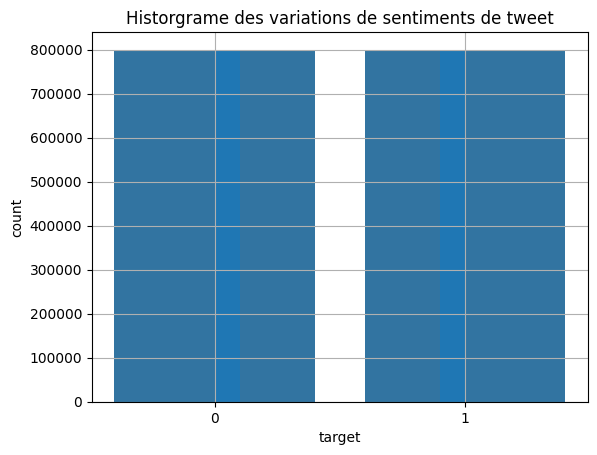

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(df_tweets.target.value_counts())
plt.title("Historgrame des variations de sentiments de tweet")
df_tweets['target'].hist()
plt.show()


In [6]:
df_tweets.loc[:,['target', 'month']].groupby('month').mean().loc[:,['target']]

,target
month,
4,0.0
5,0.0
6,0.0


In [7]:
df_tweets.dtypes

target           float64
ids                int64
date      datetime64[ns]
flag              object
user              object
text              object
year              object
month              int64
dtype: object

In [8]:
df_tweets.isnull().sum()

target    800000
ids            0
date           0
flag           0
user           0
text           0
year           0
month          0
dtype: int64

Toutes les lignes sont remplies

La catégorie target est équilibrée. Nous n'aurons pas besoin de la rééquilibrer avec imbalance ou en utilisant des paramètres de rééquilibrage lors de l'apprentissage. 

### Etude des textes de tweets

In [9]:
df_tweets['len_tweet'] = df_tweets['text'].str.len()
df_tweets['len_tweet'].describe()

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: len_tweet, dtype: float64

Les tweets ont une taille moyenne de 74 catactères. Vérifions si ils contiennent du code html ou des caractères spéciaux.

### Graphique de la taille des tweets en fonction des mois 

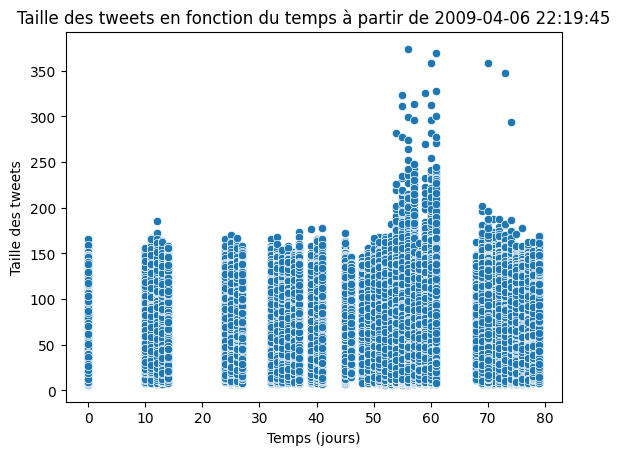

In [10]:
df_tweets['days'] = df_tweets['date'] - df_tweets['date'].min()
sns.scatterplot(data=df_tweets, y='len_tweet', x=df_tweets['days'].apply(lambda x: x.days))
plt.title(f'Taille des tweets en fonction du temps à partir de {df_tweets["date"].min()}')
plt.xlabel('Temps (jours)')
plt.ylabel('Taille des tweets')
plt.show()

En fin mai 2009, certains tweets sont plus longs. On va tracer le boxplot des tweets par moi.

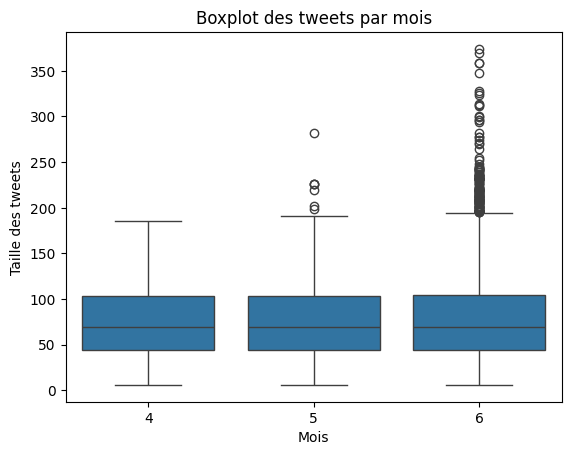

In [11]:
sns.boxplot(data=df_tweets, y='len_tweet', x='month')
plt.title('Boxplot des tweets par mois')
plt.xlabel('Mois')
plt.ylabel('Taille des tweets')
plt.show()




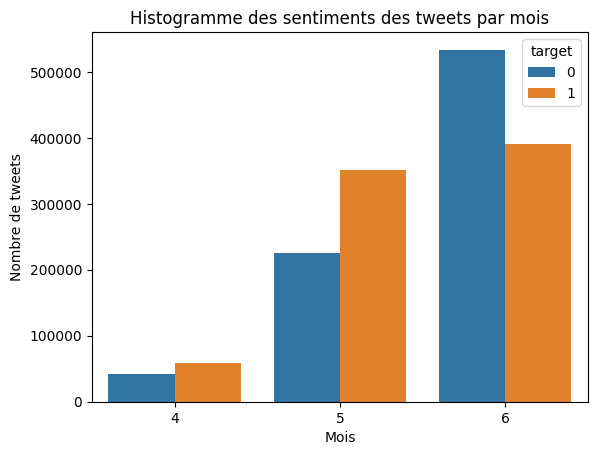

In [40]:
sns.countplot(data=df_tweets, hue='target', x='month')
plt.title('Histogramme des sentiments des tweets par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de tweets')
plt.show()


## Ids dupliqués ?

In [12]:
(df_tweets['ids'].value_counts() > 1).sum()

1685

## Vérification de la cohérence des duplications de texts 

1685 tweets semblent dupliqués, vérifions que le tweet et identique

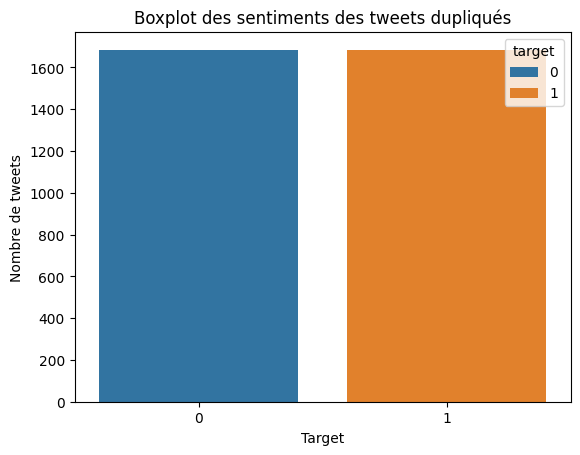

In [51]:
ids_duplicates = df_tweets['ids'].value_counts()[df_tweets['ids'].value_counts() > 1]
sns.countplot(data=df_tweets.loc[df_tweets['ids'].isin(ids_duplicates.index)],x='target', hue='target')
plt.title('Boxplot des sentiments des tweets dupliqués')
plt.xlabel('Target')
plt.ylabel('Nombre de tweets')
plt.show()



In [60]:
df_tweets.loc[df_tweets['ids'].isin(ids_duplicates.index), 'text'].reset_index(drop=True)[1]

"Haven't tweeted nearly all day  Posted my website tonight, hopefully that goes well  Night time!"

### Est ce que les Tweet sont séparables ?

In [31]:
import pandas as pd
df_tweets = pd.read_parquet("data.parquet")
sub = df_tweets.sample(frac=0.0008, random_state=42)


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2, max_df=0.95, stop_words='english')
X_t = vectorizer.fit_transform(sub['text'])

In [33]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModel.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokens = tokenizer(list(sub['text']), padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    outputs = model(**tokens)
X = outputs.last_hidden_state[:, 0, :]


In [34]:
X_dense = X.detach().cpu().numpy()
X_dense_t = X_t.toarray()
X_scaled = StandardScaler().fit_transform(X_dense)
X_scaled_t = StandardScaler().fit_transform(X_dense_t)

In [35]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)
X_pca_t = pca.fit_transform(X_scaled_t)

In [36]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42, learning_rate=200)
X_tsne = tsne.fit_transform(X_pca)
X_tsne_t = tsne.fit_transform(X_pca_t)
sub['tsne_x'] = X_tsne[:, 0]
sub['tsne_y'] = X_tsne[:, 1]
sub['tsne_x_t'] = X_tsne_t[:, 0]
sub['tsne_y_t'] = X_tsne_t[:, 1]

/Users/wonters/Desktop/openclassroom/projets/sentiment_analyses/sentimental_analyses/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/wonters/Desktop/openclassroom/projets/sentiment_analyses/sentimental_analyses/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


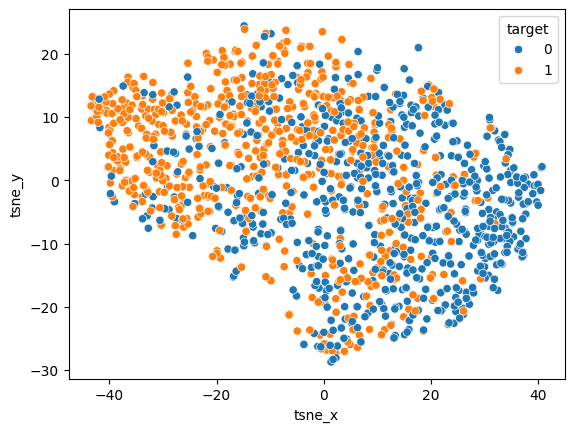

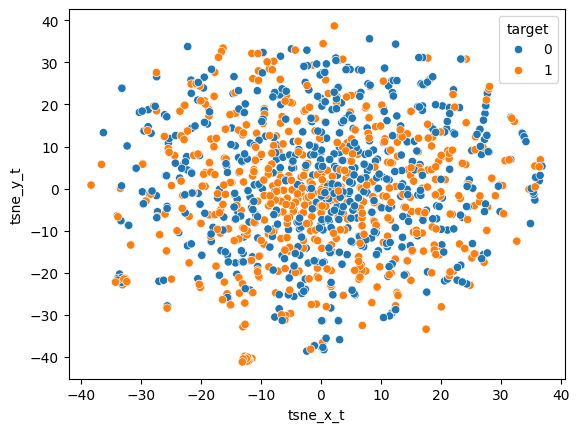

In [38]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.scatterplot(data=sub, x='tsne_x', y='tsne_y', hue='target')
plt.show()
sns.scatterplot(data=sub, x='tsne_x_t', y='tsne_y_t', hue='target')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X['tsne_x'], X['tsne_y'])
model

La fonction logistique regression devrait avoir de mauvais résultats avec des embeddings TFIDF. On va donc utiliser une autre technique.